<a href="https://colab.research.google.com/github/cleber-abreu/QuarentenaDados/blob/master/LGBMRegressor_QuarentenaDados_Desafio_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio #QuarentenaDados

Bem-vinda e bem-vindo ao desafio #QuarentenaDados valendo um **Nintendo Switch**!

Esse notebook traz informações dos dados e como você deve configurar seu arquivo final para submissão.

**Caso queira usar esse notebook como exemplo para desenvolver seu projeto, clique em file e escolha a opção Save a copy in Drive**


Vamos trabalhar com uma amostra aleatória da base de dados MICRODADOS ENEM 2018, essa amostra é **diferente da apresentada em aula**. Junto com a divulgação do resultado final estaremos disponibilizando o código que gerou os dados para que você possa analisar e reproduzir os datasets. 

Seu objetivo é prever da melhor forma possível a nota das provas de **linguagens e códigos** (NU_NOTA_LC), dado todas as outras notas. O modelo que tiver o menor **erro quadrático médio (MSE)** vence o desafio.

Para o desafio você tem três bases à disposição, duas para desenvolver seu modelo e uma para submissão da predição. As bases são as seguintes:

- **dados_treino**: São 1500000 linhas contendo a nota das 4 provas + nota de redação.

- **dados_teste**: São 20000 linhas contendo com notas das 4 provas + nota de redação.

- **dados_desafioqt**: São 10000 linhas com nota de 3 provas + nota de redação. A nota da prova de **Linguagem e Codigos** (NU_NOTA_LC) não está disponível nessa base.


As base **dados_treino e dados_teste**, contém as seguintes colunas; **NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_MT, NU_NOTA_REDACAO, NU_NOTA_LC** (Você pode consultar a aula 5, onde o Guilherme explica o significado das siglas). A coluna que você deve realizar a **previsão** é **NU_NOTA_LC**. Você pode manipular os dados da forma que quiser, o importante é que no final submeta o arquivo com as informações corretas (detalhes da submissão serão discutidos no final deste notebook).

A base **dados_desafioqt**, contém as seguintes colunas; **ID, NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_MT, NU_NOTA_REDACAO**. Repare que os dados **NU_NOTA_LC** não estão presentes, essa é justamente a informação que você precisa prever. Nós temos os valores reais das notas, no final do prazo de submissão um script irá avaliar sua previsão e dará uma nota para o seu modelo. Nessa base também temos o **ID**, essa informação é importante para o envio da sua previsão, garanta que a nota prevista corresponda ao respectivo **ID**.

Se você está habituado com o desenvolvimento de modelos de ML, repare que essa divisão de dados é exatamente a mesma que Treino, Teste e Validação. 

Abaixo preparamos um código exemplo para você seguir, sinta-se à vontade para experimentar diversos outros métodos, mas **GARANTA QUE O ARQUIVO DE SUBMISSÃO ESTEJA CONFIGURADO CORRETAMENTE**.

Na primeira parte, estamos lendo a base de dados direto de arquivos no github.






# Importando os dados

In [0]:
import pandas as pd

URI_TREINO = "https://github.com/tgcsantos/quaretenadados/blob/master/DADOS_TREINO.csv?raw=true"
URI_TESTE = "https://github.com/tgcsantos/quaretenadados/raw/master/DADOS_TESTE.csv"
URI_DESAFIOQT = "https://github.com/tgcsantos/quaretenadados/raw/master/DESAFIOQT.csv"

dados_treino = pd.read_csv(URI_TREINO)
dados_teste = pd.read_csv(URI_TESTE)
dados_desafioqt = pd.read_csv(URI_DESAFIOQT)

erro_treino = "Erro ao carregar dados de treino"
erro_teste = "Erro ao carregar dados de teste"
erro_desafioqt = "Erro ao carregar dados de submissão"

assert dados_treino.shape == (150000, 5), erro_treino
assert dados_teste.shape == (20000, 5), erro_teste
assert dados_desafioqt.shape == (10000, 5), erro_desafioqt

# Analisando os dados

In [200]:
dados_treino.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,493.890438,570.752255,528.526903,535.615000,516.269867
std,74.154695,79.399706,72.385368,103.033382,184.355231
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,435.800000,513.300000,477.900000,455.500000,360.000000
50%,483.600000,584.900000,533.400000,516.700000,520.000000
75%,542.500000,629.600000,581.400000,600.900000,640.000000
max,869.600000,825.800000,787.400000,996.100000,1000.000000


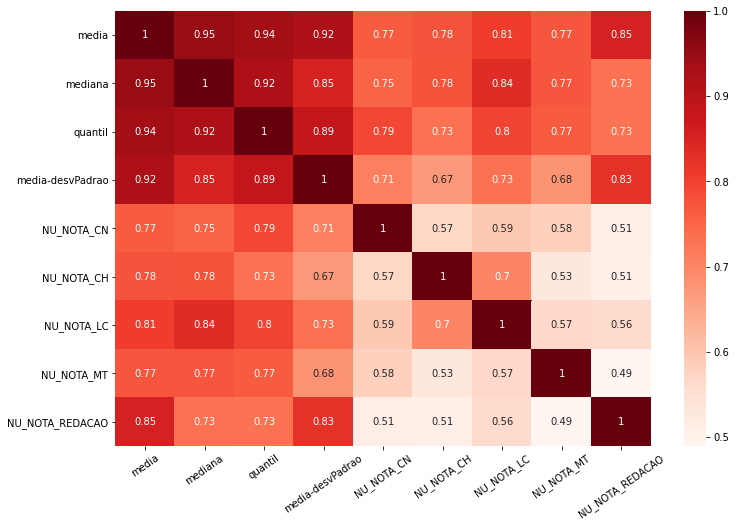

In [201]:
dados_treino_estatistica = pd.DataFrame({
                            'media': dados_treino.mean(axis=1),
                            'mediana': dados_treino.median(axis=1), 
                            'quantil': dados_treino.quantile(0.25, axis=1),
                            'media-desvPadrao': dados_treino.mean(axis=1) - dados_treino.std(axis=1)})
dados_treino_estatistica = dados_treino_estatistica.join(dados_treino)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure (figsize = (12, 8)) 
cor = dados_treino_estatistica.corr() 
sns.heatmap (cor, annot = True, cmap = plt.cm.Reds)
plt.xticks(rotation=35)
plt.show()

Maiores correlações de cada disciplina:

* `NU_NOTA_CN` x quantil = 0.8 (média=0.78)
* `NU_NOTA_CH` x média/mediana = 0.79
* `NU_NOTA_LC` x mediana = 0.83
* `NU_NOTA_MT` x média = 0.78
* `NU_NOTA_REDACAO` x média = 0.85

In [0]:
coluna_label = 'NU_NOTA_LC'
coluna_features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

# Preparação para o modelo

Agora com as bases de dados lidas, vamos separar as informações de cada dataset. X_treino e Y_treino são as **features**, X_teste e Y_teste são as **labels** a serem previstas.

Duas observações nesta parte:

- 1° Como já disponibilizamos os dados de treino e teste separados, você não precisa fazer *train_test_split* feito em aula (porém fique à vontade para trabalhar da forma que achar melhor).

- 2° Transformamos X_treino, Y_treino, X_teste, Y_teste em arrays numpy. Se você quiser usar uma biblioteca que não aceite dataframe como entrada de dados, já deixamos pronto para você.

In [0]:
X_treino = dados_treino[coluna_features].to_numpy()
Y_treino = dados_treino[coluna_label].to_numpy()
X_teste = dados_teste[coluna_features].to_numpy()
Y_teste = dados_teste[coluna_label].to_numpy()

In [204]:
!pip install scikit-optimize

In [0]:
from skopt import dummy_minimize
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

# Testes para analizar melhores parametros

In [209]:
def treinar_modelo(params):
  learning_rate = params[0]
  num_leaves = params[1]
  min_child_samples = params[2]
  subsample = params[3]
  colsample_bytree = params[4]
  n_estimators = params[5]

  print('\n', params)

  modelo = LGBMRegressor(learning_rate=learning_rate, 
                      num_leaves=num_leaves, 
                      min_child_samples=min_child_samples,
                      subsample=subsample,
                      colsample_bytree=colsample_bytree,
                      random_state=0,
                      subsample_freq=1,
                      n_estimators=n_estimators)
  modelo.fit(X_treino, Y_treino)
  predicoes = modelo.predict(X_teste)

  return mean_squared_error(Y_teste, predicoes)

space = [(1e-3, 1e-1), # leaning_rate 
        (20, 64), # num_leaves
        (67, 68), # min_child_samples
        (0.7, 1.0), # subsample
        (0.7, 1.0), # colsample_bytree
        (50, 70)] # n_estimators

resultado = dummy_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=100)

Iteration No: 1 started. Evaluating function at random point.

 [0.09972129628294801, 28, 68, 0.738437334378807, 0.9997121545972435, 50]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5662
Function value obtained: 2048.3436
Current minimum: 2048.3436
Iteration No: 2 started. Evaluating function at random point.

 [0.010141520882110983, 32, 68, 0.8036682181129143, 0.819030242269201, 68]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7920
Function value obtained: 2958.2611
Current minimum: 2048.3436
Iteration No: 3 started. Evaluating function at random point.

 [0.08478478075191571, 57, 67, 0.8573644478718614, 0.833035868133867, 64]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7775
Function value obtained: 2049.1428
Current minimum: 2048.3436
Iteration No: 4 started. Evaluating function at random point.

 [0.06737628350766184, 43, 68, 0.8676069485337254, 0.7421160815785701, 50]
Iteration No: 4 ended. Evaluation done 

A seguir criamos um modelo **Dummy** como exemplo e realizamos a avaliação do modelo com o **mean_squared_error**. 

Você pode usar qualquer algoritmo ou biblioteca para criar seus modelos, mas garanta que fará a avaliação com o mean_squared_error, pois usaremos essa métrica para avaliar sua predição final.

# Modelo Final

In [210]:
modelo = LGBMRegressor(leaning_rate=0.0765290872710539,
                      num_leaves=56,
                      min_child_samples=68,
                      subsample=0.3083468904557945,
                      colsample_bytree=0.7750117553098014,
                      #random_state=0,
                      #subsample_freq=1,
                      n_estimators=60)

modelo.fit(X_treino, Y_treino)
predicoes = modelo.predict(X_teste)

avaliacao = mean_squared_error(Y_teste, predicoes)

print(f"Minha avaliação nos dados de teste foi de {avaliacao}")

Minha avaliação nos dados de teste foi de 2041.375016431842


Depois que você criou testou e validou seu modelo, chegou a hora de preparar seu arquivo para a submissão do resultado.

No código abaixo, estamos realizando a predição das notas de **linguagem e códigos** do dataset **dados_desafioqt**. Feita a previsão, criamos um dataframe novo para a submissão, primeiro crimos a coluna **ID** e adicionamos a coluna **NU_NOTA_LC** com suas respectivas previsões (repare que nosso modelo não alterou as ordens dos ID's, mas se você utilizar algum modelo que embaralhe essa ordem certifique de colocar a previsão correta para o ID correto).

Após isso, salvamos o dataframe com ´.to_csv()´ (**importante, passe o parâmetro index=False para `.to_csv()`, caso contrário nosso script não computará sua nota**) no arquivo **PREDICAO_DESAFIOQT.csv (você precisa submeter o arquivo com esse nome, caso contrário nosso script de avaliação não computará sua nota**)  e utilizamos o `files.download` para baixar o arquivo em sua máquina local.

Feito tudo isso você está quase pronto para finalizar e submeter seu resultado. Você já baixou os dados, treinou e validou seu modelo, salvou sua previsão **no padrão ideal para submissão** e já está com o modelo baixado em sua máquina. Entretanto, ainda falta um detalhe: no momento de preencher o **forms** você precisa enviar seu código. Caso esteja usando os notebooks do colab siga as seguintes instruções para o download:

- Clique em **File** na parte superior esquerda.
- Depois selecione a opção **Download .ipynb** (também aceitaremos o .py caso você prefira desenvolver seu projeto em um arquivo python).


Pronto agora é só submeter seu resultado e torcer para levar um **Nintendo Switch** para casa.

Boa sorte!

In [0]:
#atribuir ao MODELO o nome do seu melhor modelo
from google.colab import files

MODELO = modelo
X_desafioqt = dados_desafioqt[coluna_features].to_numpy()
predicao_desafioqt = MODELO.predict(X_desafioqt)


desafio_df = pd.DataFrame(dados_desafioqt.ID)
desafio_df[coluna_label] = predicao_desafioqt

#NÃO TROCAR O NOME DO ARQUIVO DE SAÍDA (PREDICAO_DESAFIO)
desafio_df.to_csv('PREDICAO_DESAFIOQT.csv', index=False) 
files.download('PREDICAO_DESAFIOQT.csv')

# Testes com substituição dos zeros.

Não gerou bons resultados, resutando aumento no MSE

**Substituição com base nas notas de todos participantes**

In [212]:
for coluna in coluna_features:
  dados_treino.loc[dados_treino[coluna]==0, coluna] = dados_treino[coluna].mean()
  dados_teste.loc[dados_teste[coluna]==0, coluna] = dados_teste[coluna].mean()
  dados_desafioqt.loc[dados_desafioqt[coluna]==0, coluna] = dados_desafioqt[coluna].mean()

# conferindo
dados_treino.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,493.946412,571.349643,528.526903,535.679274,526.825865
std,73.968036,77.220425,72.385368,102.866163,168.599056
min,362.500000,304.200000,0.000000,364.400000,40.000000
25%,435.800000,513.600000,477.900000,455.500000,380.000000
50%,483.600000,584.900000,533.400000,516.800000,520.000000
75%,542.500000,629.600000,581.400000,600.900000,640.000000
max,869.600000,825.800000,787.400000,996.100000,1000.000000


Além da média, foi testados outras oopçôes de substituição do zeros, resultados dos MSE obtidos:

*   Média: 2081.869051176786
*   Mediana: 2083.4513385722616
*   Quantil 25%: 2091.1812195480948
*   Quantil 75%: 2130.1578740560744
*   Média - Desvio Padrao: 2079.521621271305

**Substituição dos zeros pela media do participante**

In [0]:
for coluna in coluna_features:
  dados_treino.loc[dados_treino[coluna]==0, coluna] = dados_treino[[a for a in coluna_features if a not in [coluna]]].mean(axis=1)
  dados_teste.loc[dados_teste[coluna]==0, coluna] = dados_teste[[a for a in coluna_features if a not in [coluna]]].mean(axis=1)
  dados_desafioqt.loc[dados_desafioqt[coluna]==0, coluna] = dados_desafioqt[[a for a in coluna_features if a not in [coluna]]].mean(axis=1)
  colunas_media.clear()

Conferindo...

In [214]:
dados_treino.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,493.946412,571.349643,528.526903,535.679274,526.825865
std,73.968036,77.220425,72.385368,102.866163,168.599056
min,362.500000,304.200000,0.000000,364.400000,40.000000
25%,435.800000,513.600000,477.900000,455.500000,380.000000
50%,483.600000,584.900000,533.400000,516.800000,520.000000
75%,542.500000,629.600000,581.400000,600.900000,640.000000
max,869.600000,825.800000,787.400000,996.100000,1000.000000


In [215]:
dados_teste.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,494.329558,571.757189,527.989935,534.631308,527.212699
std,73.440378,76.449856,72.244443,102.072994,168.535180
min,362.800000,387.400000,0.000000,365.300000,40.000000
25%,436.700000,515.375000,477.500000,454.400000,380.000000
50%,484.600000,585.000000,533.300000,516.500000,520.000000
75%,543.200000,629.800000,580.925000,600.200000,640.000000
max,785.000000,840.900000,747.800000,965.000000,980.000000


In [216]:
dados_desafioqt.describe()

,ID,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_REDACAO
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,493.797860,572.207394,535.468452,526.681794
std,2886.89568,73.179644,76.487014,102.723763,167.099175
min,0.00000,362.500000,394.500000,369.400000,120.000000
25%,2499.75000,436.100000,515.775000,455.200000,380.000000
50%,4999.50000,483.700000,586.300000,517.650000,520.000000
75%,7499.25000,542.700000,630.400000,601.000000,620.000000
max,9999.00000,771.100000,776.700000,946.500000,980.000000


Após a susbituição ainda nota minima zero em todas disciplinas em `dados_treino`.

Verificando se possui participante com notas zero

In [217]:
dados_treino.query('NU_NOTA_CN == 0 or NU_NOTA_CH == 0 or NU_NOTA_MT == 0 or NU_NOTA_REDACAO == 0')

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO


Removendo

In [218]:
dados_treino = dados_treino[(dados_treino != 0).all(1)]
dados_treino.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,149941.000000,149941.000000,149941.000000,149941.000000,149941.00000
mean,493.957503,571.350800,528.734872,535.702096,526.85074
std,73.973427,77.234572,71.636179,102.871001,168.61023
min,362.500000,304.200000,318.800000,364.400000,40.00000
25%,435.800000,513.600000,478.000000,455.600000,380.00000
50%,483.600000,584.900000,533.500000,516.800000,520.00000
75%,542.500000,629.700000,581.400000,601.000000,640.00000
max,869.600000,825.800000,787.400000,996.100000,1000.00000


Resultado do MSE com as substituições: 2059.6238471066126